## Pretty much just what the title says
The pipe dream here is to get edge bundling to work on a spherical map; a globe, if you will. 

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from matplotlib import cm
import cartopy.crs as ccrs
import cartopy
import geopandas as gpd
import random
import netgraph

## Basic example/formatting

In [2]:
# Generate random node data
num_nodes = 12
num_edges = 15
num_groups = 4
np.random.seed(0)  # Set seed for reproducibility

scale = 160

# Create random latitude and longitude
latitudes = np.random.uniform(-1*scale/2, 1*scale/2, num_nodes)
longitudes = np.random.uniform(-1*scale, 1*scale, num_nodes)

nodes_data = {
    'name': [f'Node{i}' for i in range(num_nodes)],
    'latitude': latitudes,
    'longitude': longitudes,
}

edges_data = {
    'source': np.random.choice(nodes_data['name'], num_edges),  # Random source nodes
    'target': np.random.choice(nodes_data['name'], num_edges),  # Random target nodes
    'weight': np.random.uniform(0.5, 3, num_edges)  # Random weights between 0.5 and 3
}

nodes_df = pd.DataFrame(nodes_data)
edges_df = pd.DataFrame(edges_data)
# Remove self-loops
edges_df = edges_df[edges_df['source'] != edges_df['target']]

In [3]:
pos = dict(zip(nodes_df['name'], zip(nodes_df['latitude'], nodes_df['longitude'])))
pos

{'Node0': (7.8101606283719605, 21.774259550058332),
 'Node1': (34.43029861958712, 136.19092425365153),
 'Node2': (16.442140171463024, -137.26846137667619),
 'Node3': (7.181309279503495, -132.11862409550696),
 'Node4': (-12.215232105775243, -153.53011281909576),
 'Node5': (23.343058090664982, 106.43835057534017),
 'Node6': (-9.986046197969202, 89.01016030395215),
 'Node7': (62.68368012513275, 118.40388743898211),
 'Node8': (74.18604168016469, 153.1578695144845),
 'Node9': (-18.649356987875564, 95.73074054935154),
 'Node10': (46.676006093226334, -12.32660407906181),
 'Node11': (4.62318716046471, 89.76933641166573)}

In [4]:
# Create a directed graph
G = nx.DiGraph()

# Add edges with weights
for idx, row in edges_df.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['weight'])

# Set positions based on latitude and longitude, converting to numpy arrays
positions = {
    row['name']: np.array([row['longitude'], row['latitude']])
    for idx, row in nodes_df.iterrows()
}

# Randomly assign a group to each node
nodes_df['group'] = np.random.choice(range(num_groups), num_nodes)

# Use a colormap to assign colors to groups
cmap = cm.get_cmap('Set2')  # Use Set2 colormap for up to num_groups
node_colors = {row['name']: cmap(row['group']) for idx, row in nodes_df.iterrows()}  # Map nodes to RGBA colors

C:\Users\elija\AppData\Local\Temp\ipykernel_52076\2230788205.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Set2')  # Use Set2 colormap for up to num_groups


In [5]:
pos = {name: np.array([lon, lat]) for name, lon, lat in zip(nodes_df['name'], nodes_df['longitude'], nodes_df['latitude'])}
pos;

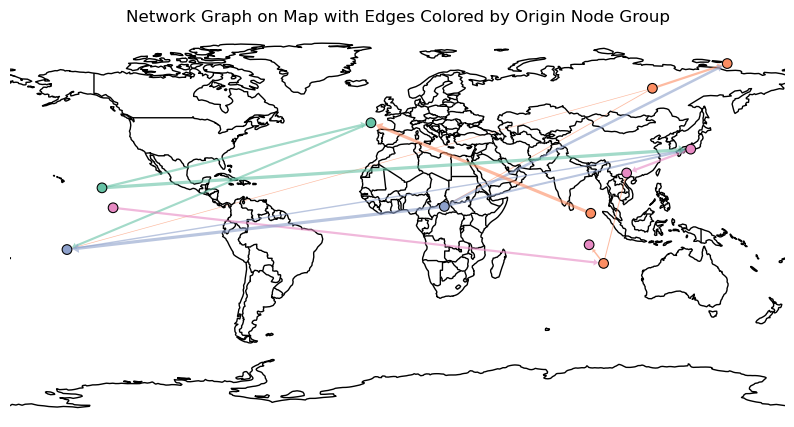

In [6]:
# Create a map using Cartopy
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Set the extent to show the area of interest (you can adjust these values)
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# Add features to the map (coastlines, borders, etc.)
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')

# Assuming your nodes have latitude and longitude information in `nodes_df`
# Create a custom node layout with geographic coordinates
node_layout = {name: (lon, lat) for name, lon, lat in zip(nodes_df['name'], nodes_df['longitude'], nodes_df['latitude'])}

edge_colors = {
    (source, target): node_colors[source]
    for source, target in zip(edges_df['source'], edges_df['target'])
}

# Now plot the network on top of the map with edges colored by the source node's group
netgraph.Graph(
    G,
    node_layout=pos,
    node_color=node_colors,
    edge_width={(u, v): d['weight']*50 for u, v, d in G.edges(data=True)},
    node_edge_width=50,
    node_size=250,
    node_edge_color='black',
    node_labels=False,
    arrows=True,
    edge_layout='curved', 
#     edge_layout_kwargs=dict(compatibility_threshold=0, k=0, total_cycles=8, total_iterations=100, step_size=.01),
    edge_color=edge_colors,  # Use the computed edge colors as a dictionary
    edge_alpha=0.6,
    prettify=True,
    ax=ax  # Plot on the same axes as the map
)

# Add title
plt.title("Network Graph on Map with Edges Colored by Origin Node Group")

# Show the plot
plt.show()

## The difference between indentical graphs at different scales

C:\Users\elija\anaconda3\Lib\site-packages\netgraph\_edge_layout.py:978: RuntimeWarning: invalid value encountered in divide
  displacement = compatibility * delta / distance_squared[..., None]


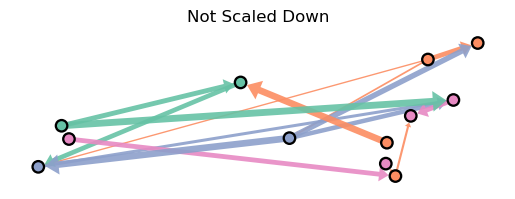

In [7]:
pos = {name: np.array([lon, lat]) for name, lon, lat in zip(nodes_df['name'], nodes_df['longitude'], nodes_df['latitude'])}
edge_colors = {
    (source, target): node_colors[source]
    for source, target in zip(edges_df['source'], edges_df['target'])
}

netgraph.Graph(
    G,
#     node_layout='community', node_layout_kwargs=dict(node_to_community=dict(zip(nodes_df['name'], nodes_df['group']))),
    node_layout = pos,
    node_color=node_colors,
    edge_width={(u, v): d['weight']*scale for u, v, d in G.edges(data=True)},
    node_edge_width=scale,
    node_size=3*scale,
    node_edge_color='black',
    node_labels=False,
    arrows=True,
    edge_layout='bundled', 
    edge_layout_kwargs=dict(compatibility_threshold=0.00, k=0, straighten_by=0),
    edge_color=edge_colors,  # Use the computed edge colors as a dictionary
    edge_alpha=0.9,
    prettify=True,
)
plt.title('Not Scaled Down')
plt.show()

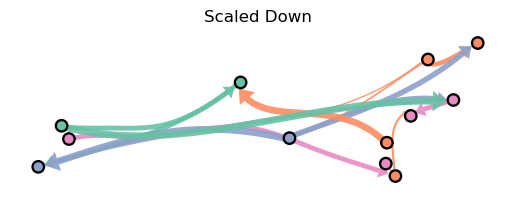

In [8]:
# base range of 1
pos = {name: np.array([lon/scale, lat/scale]) for name, lon, lat in zip(nodes_df['name'], nodes_df['longitude'], nodes_df['latitude'])}

netgraph.Graph(
    G,
#     node_layout='community', node_layout_kwargs=dict(node_to_community=dict(zip(nodes_df['name'], nodes_df['group']))),
    node_layout = pos,
    node_color=node_colors,
    edge_width={(u, v): d['weight'] for u, v, d in G.edges(data=True)},
    node_edge_width=1,
    node_size=3,
    node_edge_color='black',
    node_labels=False,
    arrows=True,
    edge_layout='bundled', 
#     edge_layout_kwargs=dict(compatibility_threshold=0, k=1000, straighten_by=0),
    edge_color=edge_colors,  # Use the computed edge colors as a dictionary
    edge_alpha=0.9,
    prettify=True,
)
plt.title('Scaled Down')
plt.show()

## Scaling down, performing bundling, then scaling back up (and using `Cartopy`)
This doesn't look half bad, but it only works with `ccrs.PlateCarree`; using any other projections causes the graph to not appear. To get around this, we have to not use `netgraph` and instead plot the lines using `matplotlib` directly. 

In [9]:
pos = {name: np.array([lon, lat]) for name, lon, lat in zip(nodes_df['name'], nodes_df['longitude'], nodes_df['latitude'])}

scaled_pos = dict(pd.DataFrame(pos)/scale)

edges = list(G.edges)

"https://netgraph.readthedocs.io/en/latest/edge_layout.html#netgraph.get_bundled_edge_paths"
paths = netgraph.get_bundled_edge_paths(edges=edges, 
                                node_positions=scaled_pos,
#                                 compatibility_threshold=0,
#                                 straighten_by=0.1,
                                step_size=0.04)

for key, value in paths.items():
    paths[key] = value * scale

paths;

In [ ]:
# Create a map using Cartopy
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Set the extent to show the area of interest (you can adjust these values)
ax.set_global()

# Add features to the map (coastlines, borders, etc.)
# uses https://scitools.org.uk/cartopy/docs/latest/reference/generated/cartopy.mpl.feature_artist.FeatureArtist.html

ax.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.1)
ax.add_feature(cartopy.feature.LAND, color='#b7e8bf')
ax.add_feature(cartopy.feature.OCEAN, color='lightblue')
ax.add_feature(cartopy.feature.COASTLINE, linewidth=.2)
# ax.stock_img()

netgraph.Graph(
    G,
    node_layout = pos,
    node_color=node_colors,
    edge_width={(u, v): d['weight']*scale/3 for u, v, d in G.edges(data=True)},
    node_edge_width=.5*scale,
    node_size=2*scale,
    node_edge_color='black',
    node_labels=False,
    arrows=True,
    edge_layout=paths, 
    edge_color='maroon', 
    edge_alpha=0.6,
    prettify=True,
    ax=ax,
)

plt.title('Scaling down, bundling, then scaling up and graphing with cartopy and netgraph')
plt.xlabel("This graph shows communications between friends on various cruises around\nthe world, \
but it's tornado season in Siberia and the South China Sea, and one of them is\n \
actually on a safari in the Central African Republic.", fontsize=10)
plt.show()

## Attempting to get Robinson to work
And hey, it does! We lose our arrows, because we're no longer plotting with `netgraph`, but I'm still chalking that up as a win. 

In [ ]:
weights = {(u, v): d['weight']*scale/3 for u, v, d in G.edges(data=True)}

# Create a map using Cartopy
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.Robinson()})

# Set the extent to show the area of interest (you can adjust these values)
ax.set_global()

# Add features to the map (coastlines, borders, etc.)
# uses https://scitools.org.uk/cartopy/docs/latest/reference/generated/cartopy.mpl.feature_artist.FeatureArtist.html

ax.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.1)
ax.add_feature(cartopy.feature.LAND, color='#b7e8bf')
ax.add_feature(cartopy.feature.OCEAN, color='lightblue')
ax.add_feature(cartopy.feature.COASTLINE, linewidth=.2)
# ax.stock_img()

for nodes, path in paths.items():
    ax.plot(path[:, 0], path[:, 1],
            color='maroon',
            linewidth=weights[nodes]/50,
            alpha=.6,
            transform=ccrs.PlateCarree()
            )
    
    
for node, loc in pos.items():
    ax.plot(loc[0], loc[1], 
            'o', color=node_colors[node],
            markersize=8,
            markeredgecolor='black', markeredgewidth=2,
            transform=ccrs.PlateCarree())


plt.show()

## Experimenting with Folium
Folium is cranky. Neither `Circle` nor `CircleMarker` really let you zoom and play with the map: `Circle` causes nodes to be different sizes because of the projections, and `CircleMarker` gets smaller as you zoom in until it isn't touching its edges anymore.<sup>1</sup> Not having smooth interactive elements takes away the biggest draw of Folium, in my opinion.

<sup>1</sup> `Polygon` has the same problem as `Circle`. 

In [ ]:
import folium
import matplotlib as mpl

In [ ]:
m = folium.Map(tiles="Cartodb Positron", prefer_canvas =True,
#                min_zoom=1, max_zoom=2
              )

weights = {(u, v): d['weight']*scale/3 for u, v, d in G.edges(data=True)}
for nodes, path in paths.items():
    
    folium.PolyLine(path[:, [1, 0]], 
                    tooltip=nodes,
                    color="maroon", opacity=.6,
                    weight=weights[nodes]/50,
#                     smooth_factor=50,
                   ).add_to(m)
    
for node, loc in pos.items():
    folium.CircleMarker(
        location=[loc[1], loc[0]],
        tooltip=node,
        radius=6,
        color='black',
        fill_color=mpl.colors.rgb2hex(node_colors[node]),
        fill=True,
        fill_opacity=1,
    ).add_to(m)

m